# Physique des Marchés, TP1 : Faits Stylisés
**Martin Pasche -- Hugo Yeremian**

### Libraries

In [1]:
import sys
import os
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import scipy.stats as stats
import seaborn as sns


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import norm, gaussian_kde, expon, mstats, laplace
from statsmodels.graphics.gofplots import qqplot
from statsmodels.distributions.empirical_distribution import ECDF

/Users/hugo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Helper function

In [2]:
files = sorted(glob.glob("data/2017-*-AAPL.OQ-bbo.csv.gz"))

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# function not directly in my folder
from loadbbo import load_TRTH_bbo

# 2. Obtenir des données

## 2.1. Données Journalières

In [3]:
aapl = yf.Ticker('AAPL')
data_daily = aapl.history(interval='1d', start='2002-01-02')
data_daily.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-01-02 00:00:00-05:00,0.331782,0.350590,0.330428,0.350590,529496800,0.0,0.0
2002-01-03 00:00:00-05:00,0.346076,0.357361,0.342615,0.354803,612007200,0.0,0.0
2002-01-04 00:00:00-05:00,0.351193,0.360371,0.345926,0.356459,409976000,0.0,0.0
2002-01-07 00:00:00-05:00,0.356910,0.361123,0.342315,0.344572,444584000,0.0,0.0
2002-01-08 00:00:00-05:00,0.342315,0.346829,0.337951,0.340208,450038400,0.0,0.0


## 2.2. Données Intraday

In [4]:
data_list = [load_TRTH_bbo(file) for file in files]
data_intraday = pd.concat(data_list)

# 3. Calcul des rendements

## 3.1 Données Journalières

In [5]:
data_daily["Returns"] = np.log(data_daily["Close"]).diff()
returns_daily = data_daily["Returns"].dropna()

Text(0.5, 1.0, 'Daily log returns of AAPL Stock')

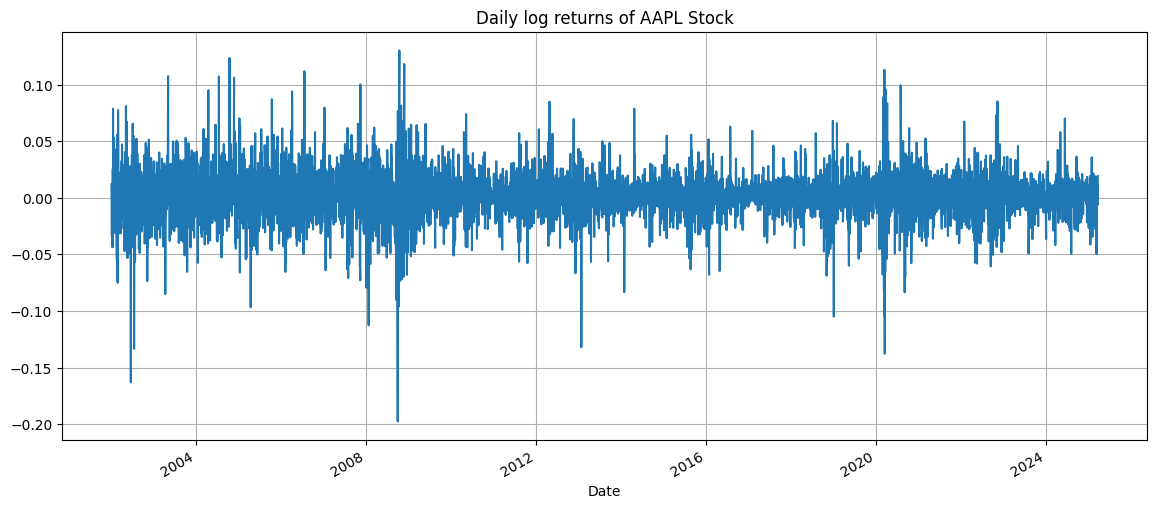

In [6]:
plt.figure(figsize=(14, 6))
returns_daily.plot()
plt.grid()
plt.title('Daily log returns of AAPL Stock')

Text(0.5, 1.0, 'Cumulative Return (from Log-Returns) of AAPL')

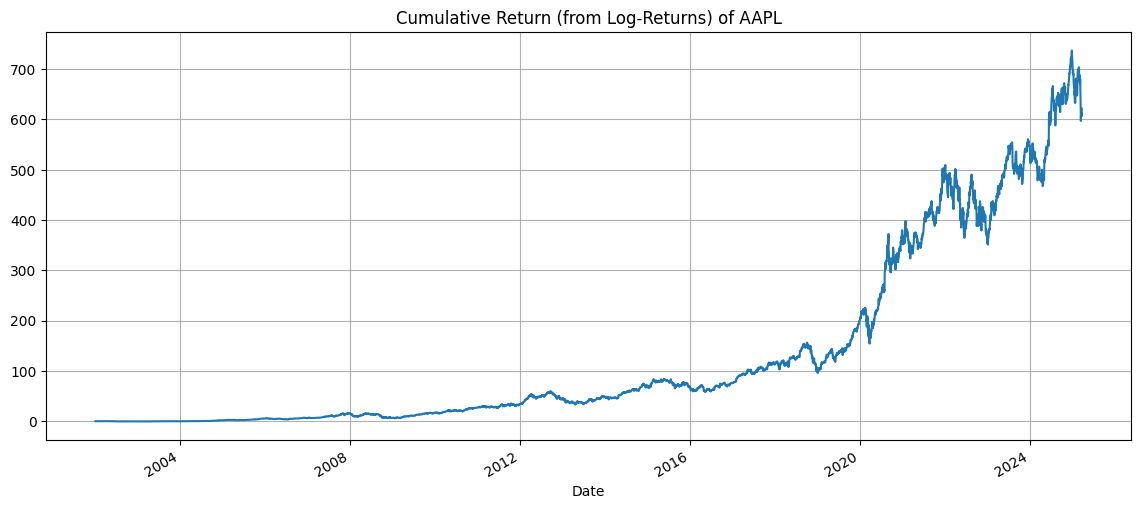

In [7]:
plt.figure(figsize=(14, 6))
# total percentage of cumulative return
(np.exp(returns_daily.cumsum()) - 1).plot()
plt.grid()
plt.title("Cumulative Return (from Log-Returns) of AAPL")

## 3.2 Données Intraday

### 3.2.1. Sanity Checks

In [8]:
# be sure that the markets are open ub the US (AAPL Stock)
data_intraday = data_intraday.between_time('09:30:00','16:00:00')

# exact same lines are avoided with same timestamps
data_intraday = data_intraday.reset_index().drop_duplicates().set_index("xltime")

# be sure of the timeline
data_intraday = data_intraday.sort_index()

# sanity checks of quantities
data_intraday = data_intraday[
    (data_intraday["bid-price"] > 0) &
    (data_intraday["ask-price"] > 0) &
    (data_intraday["bid-volume"] > 0) &
    (data_intraday["ask-volume"] > 0)
]

### 3.2.2 Transformations et Ajout d'informations



In [9]:
data_intraday['Mid-Price'] = (data_intraday['bid-price'] + data_intraday['ask-price']) / 2
log_mid_returns = np.log(data_intraday['Mid-Price']).diff()

# you sum to resample ln(P_30secs / P_0)
returns_30s = log_mid_returns.resample('30s').sum()
returns_5s = log_mid_returns.resample('5s').sum()
returns_1m = log_mid_returns.resample('1min').sum()
returns_5m = log_mid_returns.resample('5min').sum()

returns_30s = returns_30s.dropna()
returns_5s = returns_5s.dropna()
returns_1m = returns_1m.dropna()
returns_5m = returns_5m.dropna()

# cumulative log returns
cumulative_returns_30s = returns_30s.cumsum()
cumulative_returns_5s = returns_5s.cumsum()
cumulative_returns_1m = returns_1m.cumsum()
cumulative_returns_5m = returns_5m.cumsum()

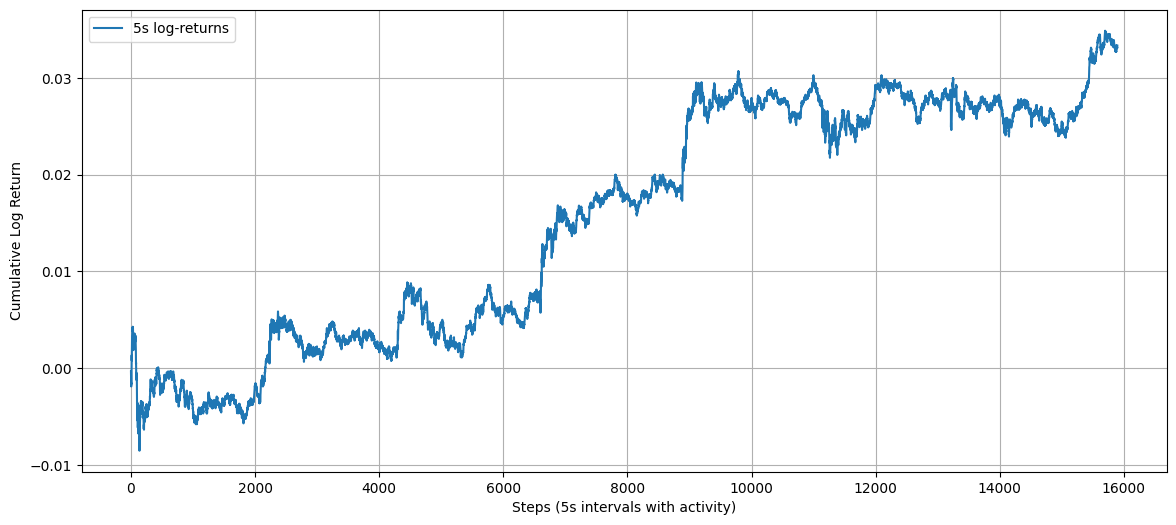

In [10]:
# to visualy not see gaps
returns_5s_plot = returns_5s[returns_5s != 0]
# with filter of 0 values
cum_returns_5s = returns_5s_plot.cumsum()

plt.figure(figsize=(14, 6))
plt.plot(cum_returns_5s.values, label='5s log-returns')
plt.xlabel('Steps (5s intervals with activity)')
plt.ylabel('Cumulative Log Return')
plt.grid()
plt.legend()
plt.show()


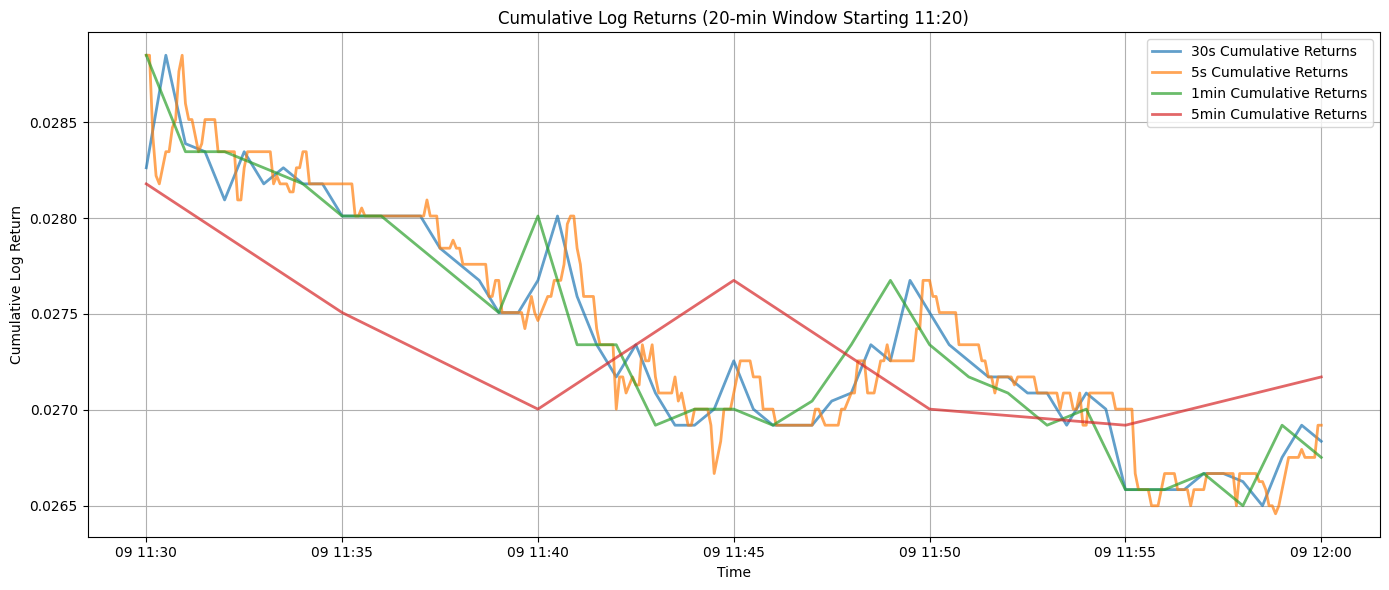

In [11]:
start_time = '2017-01-09 11:30:00'
end_time = '2017-01-09 12:00:00'

# Slicing window
window_30s = cumulative_returns_30s.loc[start_time:end_time]
window_5s = cumulative_returns_5s.loc[start_time:end_time]
window_1m = cumulative_returns_1m.loc[start_time:end_time]
window_5m = cumulative_returns_5m.loc[start_time:end_time]

plt.figure(figsize=(14, 6))
plt.plot(window_30s, label='30s Cumulative Returns', linewidth=2, alpha=0.7)
plt.plot(window_5s, label='5s Cumulative Returns', linewidth=2, alpha=0.7)
plt.plot(window_1m, label='1min Cumulative Returns', linewidth=2, alpha=0.7)
plt.plot(window_5m, label='5min Cumulative Returns', linewidth=2, alpha=0.7)
plt.title('Cumulative Log Returns (20-min Window Starting 11:20)')
plt.xlabel('Time')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Analyse Empirique
## 4.1 Rendements : types de distribution
### 4.1.1. Gaussianité : Données Journalières

In [12]:
returns_daily = returns_daily[returns_daily != 0]

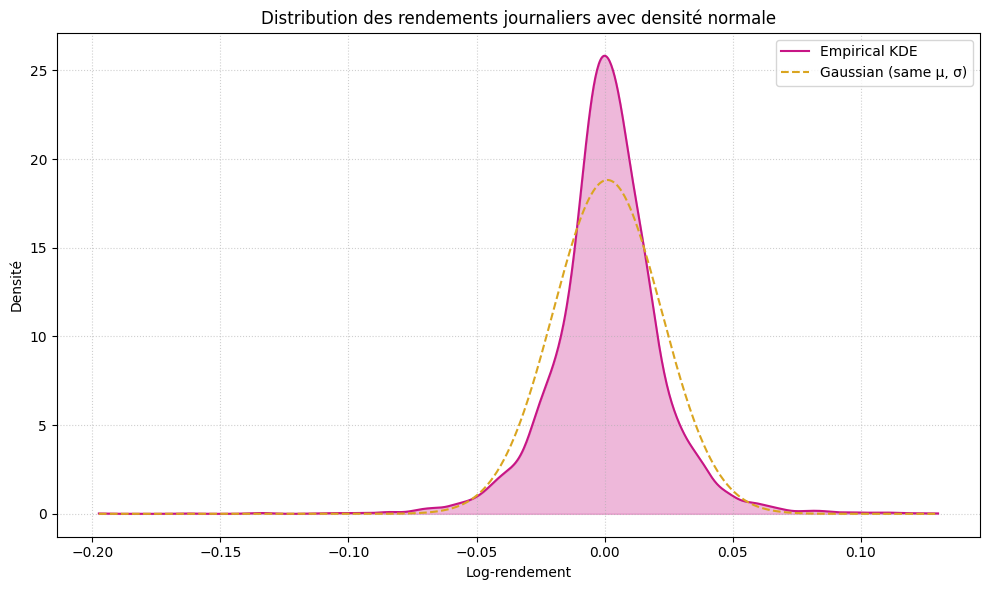

In [13]:
x = np.linspace(returns_daily.min(), returns_daily.max(), 1000)

kde = gaussian_kde(returns_daily)
kde_values = kde(x)
gaussian_pdf = norm.pdf(x, loc=returns_daily.mean(), scale=returns_daily.std())

plt.figure(figsize=(10, 6))
plt.plot(x, kde_values, label='Empirical KDE', color='mediumvioletred')
plt.fill_between(x, kde_values, alpha=0.3, color='mediumvioletred')
plt.plot(x, gaussian_pdf, label='Gaussian (same μ, σ)', linestyle='--', color='goldenrod')
plt.title("Distribution des rendements journaliers avec densité normale")
plt.xlabel("Log-rendement")
plt.ylabel("Densité")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

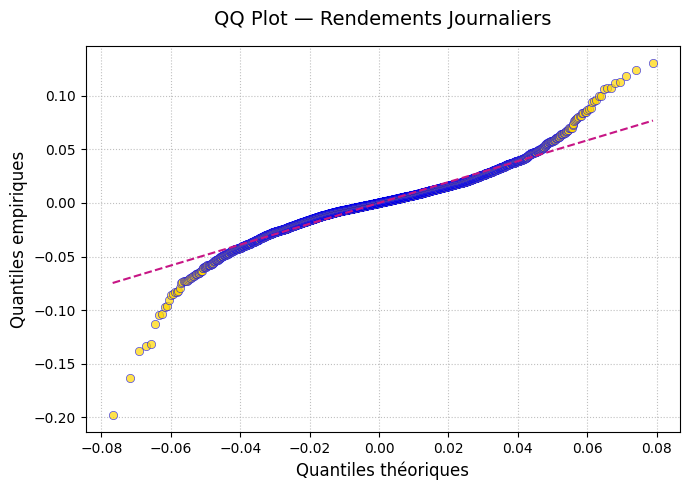

In [14]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

stats.probplot(returns_daily, dist="norm", 
               sparams=(np.mean(returns_daily), np.std(returns_daily)), 
               plot=ax)

ax.get_lines()[1].set_color("mediumvioletred")
ax.get_lines()[1].set_linestyle("--")
ax.get_lines()[0].set_markerfacecolor("gold")
ax.get_lines()[0].set_markeredgewidth(0.5)
ax.get_lines()[0].set_alpha(0.7)
ax.set_title("QQ Plot — Rendements Journaliers", fontsize=14, pad=15)
ax.set_xlabel("Quantiles théoriques", fontsize=12)
ax.set_ylabel("Quantiles empiriques", fontsize=12)
ax.grid(True, linestyle=":", alpha=0.8)

plt.tight_layout()
plt.show()


### 4.1.1. Gaussianité : Données Intraday

In [15]:
returns_1m = returns_1m[returns_1m != 0]

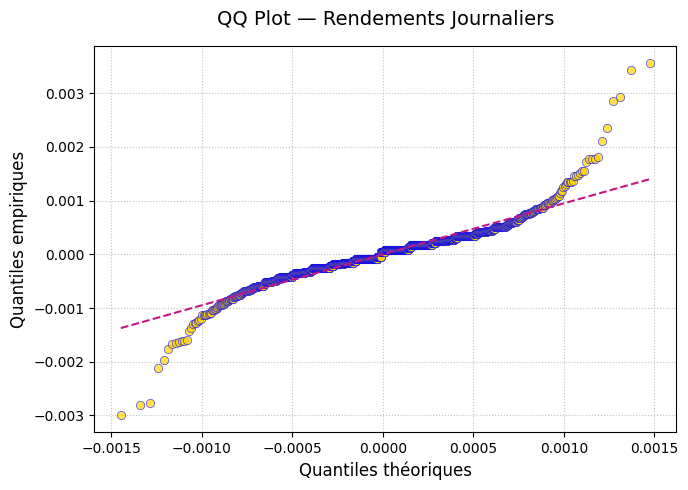

In [16]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

stats.probplot(returns_1m, dist="norm", 
               sparams=(np.mean(returns_1m), np.std(returns_1m)), 
               plot=ax)

ax.get_lines()[1].set_color("mediumvioletred")
ax.get_lines()[1].set_linestyle("--")
ax.get_lines()[0].set_markerfacecolor("gold")
ax.get_lines()[0].set_markeredgewidth(0.5)
ax.get_lines()[0].set_alpha(0.7)
ax.set_title("QQ Plot — Rendements Journaliers", fontsize=14, pad=15)
ax.set_xlabel("Quantiles théoriques", fontsize=12)
ax.set_ylabel("Quantiles empiriques", fontsize=12)
ax.grid(True, linestyle=":", alpha=0.8)

plt.tight_layout()
plt.show()

#### Interprétation :

Dans les deux cas, la distribution observée s’écarte nettement de la loi normale. Toutefois, on remarque qu’en diminuant la fréquence d’échantillonnage des rendements, la distribution tend à avoir des queues moins épaisses.

### 4.1.2. Comparaison des rendements intraday :

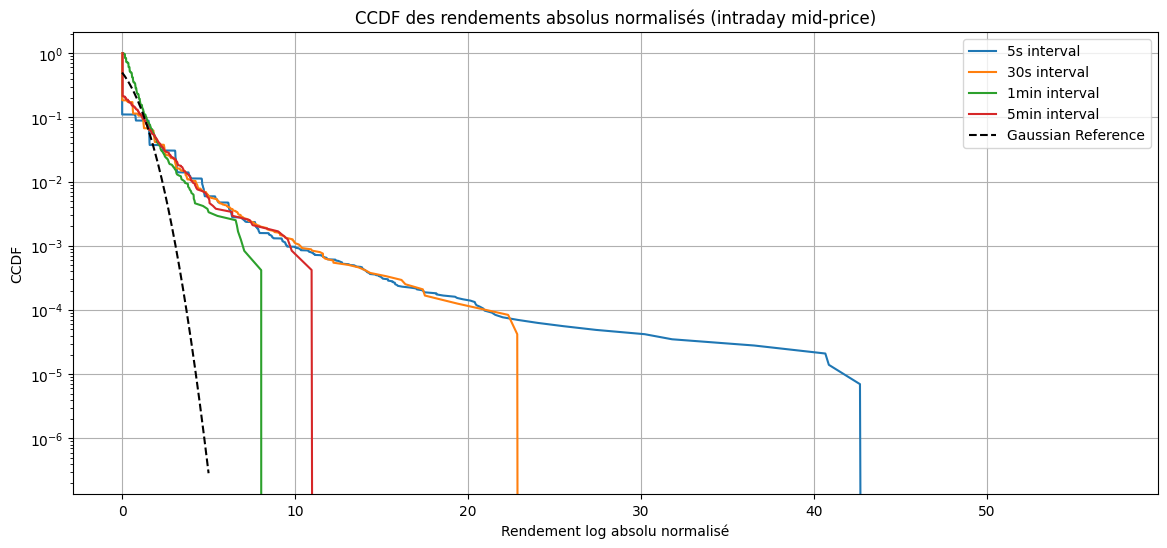

In [17]:
plt.figure(figsize=(14, 6))

returns_dict = {
    '5s': returns_5s,
    '30s': returns_30s,
    '1min': returns_1m,
    '5min': returns_5m
}

for label, returns in returns_dict.items():
    # Normalisation des rendements (z-score)
    normalized_abs_returns = np.abs((returns - returns.mean()) / returns.std())

    # CCDF
    sorted_data = np.sort(normalized_abs_returns)
    ccdf = 1. - np.arange(1, len(sorted_data)+1) / len(sorted_data)

    plt.semilogy(sorted_data, ccdf, label=f'{label} interval')

# Courbe de référence gaussienne
gaussian_x = np.linspace(0, 5, 1000)
gaussian_ccdf = 1. - stats.norm.cdf(gaussian_x)
plt.semilogy(gaussian_x, gaussian_ccdf, 'k--', label='Gaussian Reference')

plt.title('CCDF des rendements absolus normalisés (intraday mid-price)')
plt.xlabel('Rendement log absolu normalisé')
plt.ylabel('CCDF')
plt.legend()
plt.grid(True)
plt.show()


### 4.2.1 Queues Lourdes : Données Journalières

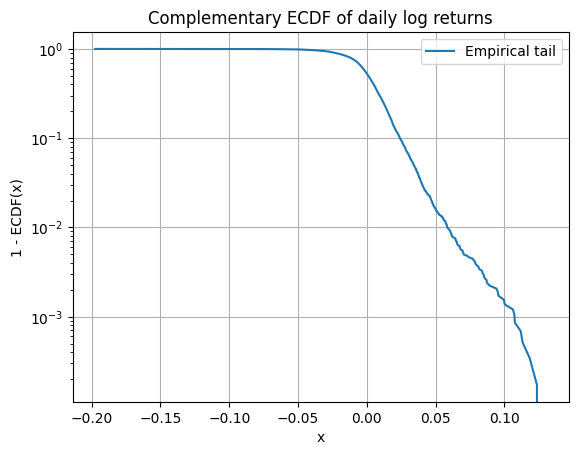

In [18]:
cdflr = ECDF(returns_daily.to_numpy())

# Loi du survivant
plt.plot(cdflr.x, 1 - cdflr.y, label='Empirical tail')

plt.yscale('log')
plt.title('Complementary ECDF of daily log returns')
plt.xlabel('x')
plt.ylabel('1 - ECDF(x)')
plt.legend()
plt.grid(True)


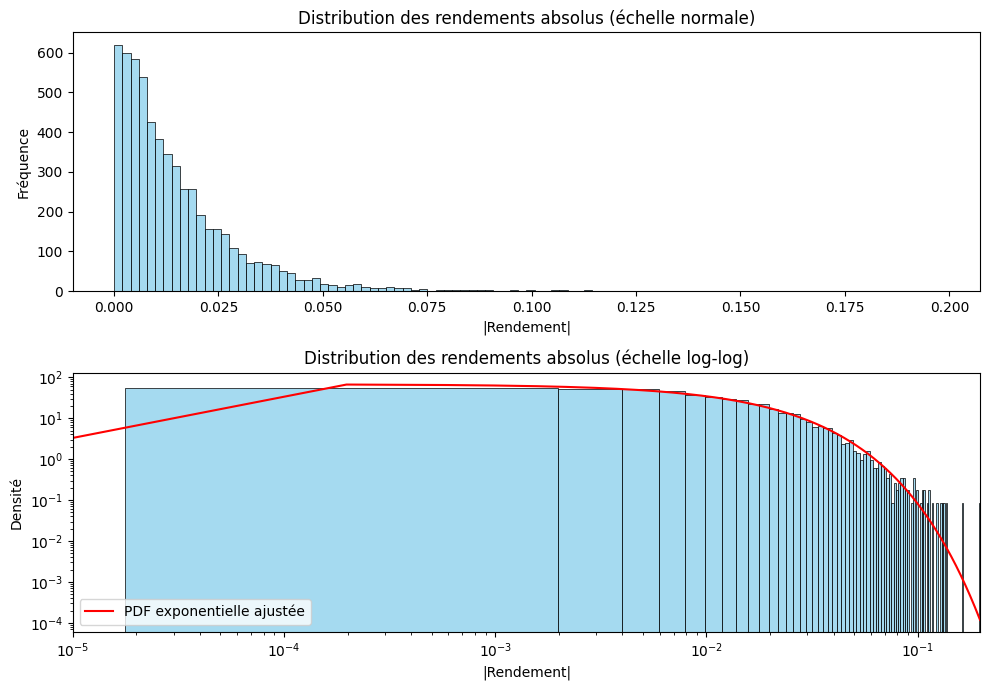

In [19]:
abs_returns = np.abs(returns_daily)
loc, scale = stats.expon.fit(abs_returns)   

x_fit = np.linspace(0, np.max(abs_returns), 1000)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

sns.histplot(abs_returns, kde=False, ax=axes[0], bins=100, color='skyblue')
axes[0].set_title('Distribution des rendements absolus (échelle normale)')
axes[0].set_xlabel('|Rendement|')
axes[0].set_ylabel('Fréquence')

sns.histplot(abs_returns, kde=False, stat='density', bins=100, ax=axes[1], color='skyblue')
sns.lineplot(x=x_fit, y=y_fit, color='red', ax=axes[1], label='PDF exponentielle ajustée')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(1e-5, np.max(abs_returns))
axes[1].set_xlabel('|Rendement|')
axes[1].set_ylabel('Densité')   
axes[1].set_title('Distribution des rendements absolus (échelle log-log)')
axes[1].legend()

plt.tight_layout()
plt.show()


#### Interprétation: (pour le premier graphe vu en cours)

Queue plus lourde que l’exponentielle par la concavité du profil de la fonction du survivant.

$$\mathbb{P}(X > x) = \exp(-x) \Rightarrow \log \mathbb{P}(X > x) = -x$$

Donc en échelle semi-log, on aurait une ligne droite de pente -1.

Il y a plus de valeurs extrêmes que prévu par une loi exponentielle -> queue lourde.

### 4.2.2 Queues Lourdes : Données Intraday

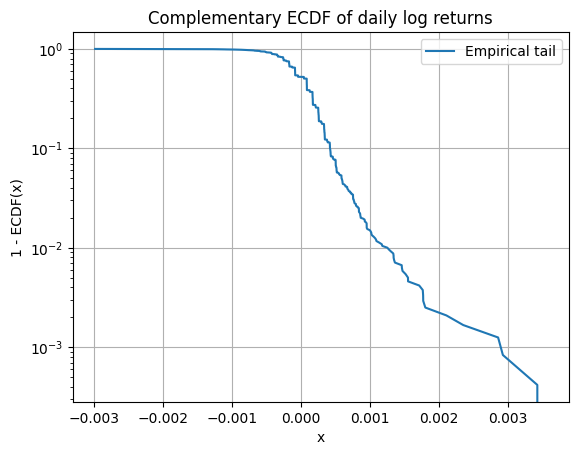

In [20]:
cdflr = ECDF(returns_1m.to_numpy())

# Loi du survivant
plt.plot(cdflr.x, 1 - cdflr.y, label='Empirical tail')

plt.yscale('log')
plt.title('Complementary ECDF of daily log returns')
plt.xlabel('x')
plt.ylabel('1 - ECDF(x)')
plt.legend()
plt.grid(True)

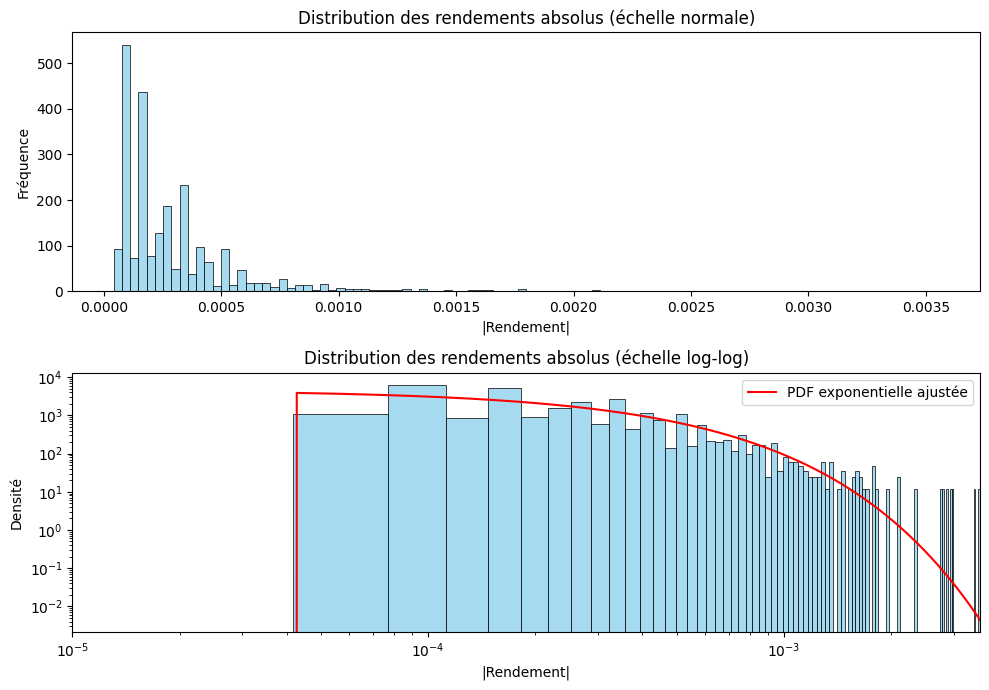

In [21]:
abs_returns = np.abs(returns_1m)
loc, scale = stats.expon.fit(abs_returns)   

x_fit = np.linspace(0, np.max(abs_returns), 1000)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

sns.histplot(abs_returns, kde=False, ax=axes[0], bins=100, color='skyblue')
axes[0].set_title('Distribution des rendements absolus (échelle normale)')
axes[0].set_xlabel('|Rendement|')
axes[0].set_ylabel('Fréquence')

sns.histplot(abs_returns, kde=False, stat='density', bins=100, ax=axes[1], color='skyblue')
sns.lineplot(x=x_fit, y=y_fit, color='red', ax=axes[1], label='PDF exponentielle ajustée')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(1e-5, np.max(abs_returns))
axes[1].set_xlabel('|Rendement|')
axes[1].set_ylabel('Densité')   
axes[1].set_title('Distribution des rendements absolus (échelle log-log)')
axes[1].legend()

plt.tight_layout()
plt.show()


### Interprétation: (supplémentaire par deuxième graphe)
On remarque qu'encore plus d'évènements viennent conclure à une densité non exponentielle, au-delà même de l'hypothèse que les rendements à valeur absolue proche de 0, on remarque qu'ici c'est toutes les valeurs de rendements possibles qui ne suivent pas de loi exponentielle.

### 4.3.1. QQ-Plot de distribution exponentielle : Données Journalières

On considère une variable aléatoire réelle $r$, typiquement un **rendement logarithmique**.

On définit une version **normalisée** :

$$
x = \frac{|r|}{\mathbb{E}(|r|)}
$$

Cela permet de supprimer l'effet d'échelle et de comparer la forme de la distribution (notamment dans la queue) à celle d'une loi exponentielle de moyenne 1.

In [ ]:
r = returns_daily.to_numpy()
r_normalized = np.abs(r) / np.mean(np.abs(r))

# calcul des quantiles empiriques sur une grille de probas phi
r_sorted = np.sort(r_normalized)
n = len(r_sorted)

# générer une grille de probabilités entre 0 et 1
phi = np.linspace(1 / (n + 1), n / (n + 1), n)

# quantiles d'une loi exp(1)
q_exp = -np.log(1 - phi)

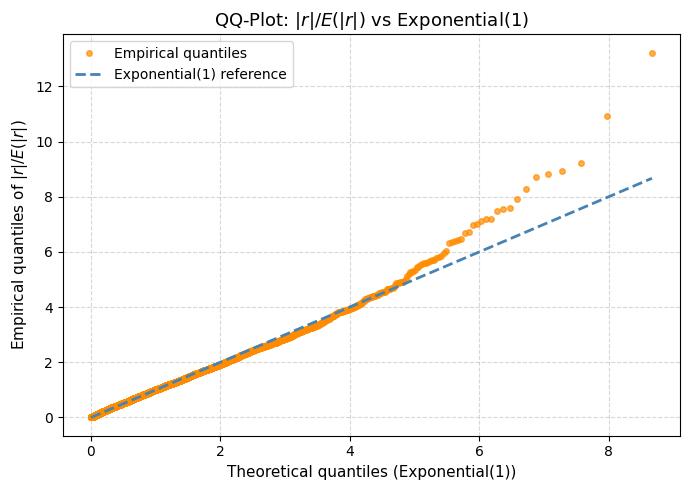

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(q_exp, r_sorted, 'o', markersize=4, alpha=0.7, color='darkorange', label='Empirical quantiles')
plt.plot(q_exp, q_exp, '--', color='steelblue', linewidth=2, label='Exponential(1) reference')

plt.xlabel('Theoretical quantiles (Exponential(1))', fontsize=11)
plt.ylabel('Empirical quantiles of $|r|/E(|r|)$', fontsize=11)
plt.title('QQ-Plot: $|r|/E(|r|)$ vs Exponential(1)', fontsize=13)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Interprétation :

La queue de la distribution est plus lourde que celle de l'exponentielle — ce qui est un signal fort de heavy tails comme précédemment testé. Fait stylisé vérifé !

### 4.4.1. Calcul de la distance maximale entre les quantiles empiriques de |r|/E(|r|) et les quantiles d’une distribution exponentielle de moyenne 1

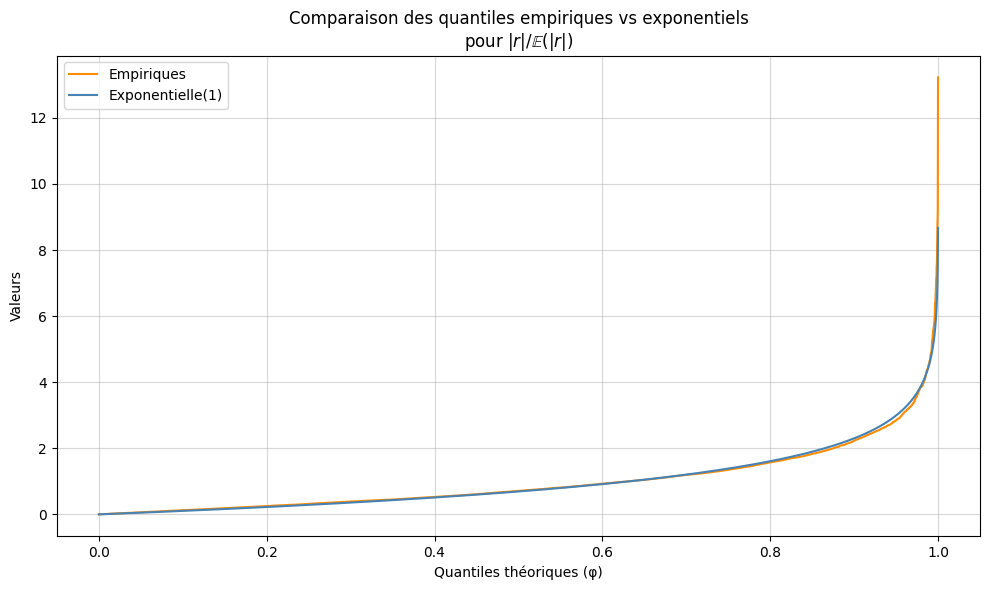

In [ ]:
#q_emp = mstats.mquantiles(r_normalized, prob=phi)
q_emp = r_sorted

plt.figure(figsize=(10, 6))
plt.plot(phi, q_emp, label="Empiriques", color='darkorange')
plt.plot(phi, q_exp, '-', label="Exponentielle(1)", color='steelblue')

plt.xlabel("Quantiles théoriques (φ)")
plt.ylabel("Valeurs")
plt.title("Comparaison des quantiles empiriques vs exponentiels\npour $|r|/\mathbb{E}(|r|)$")
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Distance maximale quantiles empiriques et exponentiels')

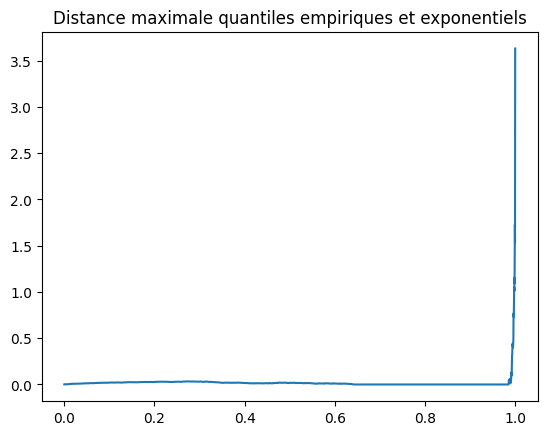

In [25]:
plt.plot(phi,np.maximum(q_emp - q_exp, 0))
plt.title("Distance maximale quantiles empiriques et exponentiels")

In [26]:
distance_maximale = np.max(np.maximum(q_emp - q_exp, 0))
print("Distance maximale entre les quantiles exp et empirique: ", distance_maximale)

Distance maximale entre les quantiles exp et empirique:  3.632306742083207


### 4.5.1. Génération de rendements iid par Laplace

In [35]:
laplace_r = laplace.rvs(size=1_000_000)
laplace_normalized = np.abs(laplace_r) / np.mean(np.abs(laplace_r))

# Quantiles empiriques de la variable normalisée Laplace
q_emp_laplace = mstats.mquantiles(laplace_normalized, prob=phi)

excess_laplace = np.maximum(q_emp - q_emp_laplace,0)
distance_max_laplace = np.max(excess_laplace)

print("Distance max (Laplace vs Exponentielle) :", distance_max_laplace)

Distance max (Laplace vs Exponentielle) : 3.5377282519444684


/var/folders/nd/lbp9nypd0l328jm0b27jr8c00000gn/T/ipykernel_11372/3189667077.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


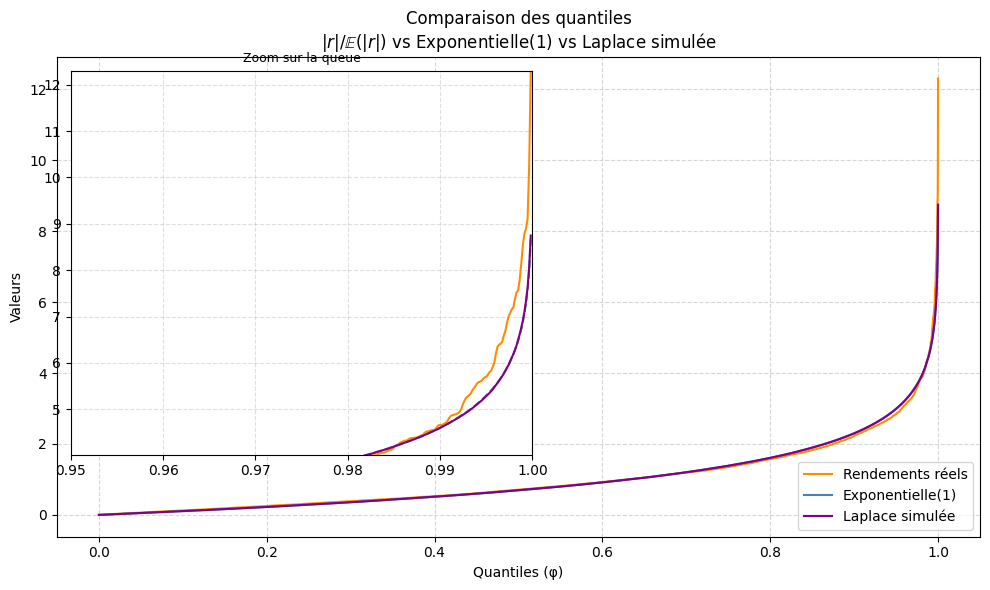

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(phi, q_emp, label="Rendements réels", color='darkorange')
ax.plot(phi, q_exp, label="Exponentielle(1)", color='steelblue')
ax.plot(phi, q_emp_laplace, label="Laplace simulée", color='purple')

ax.set_xlabel("Quantiles (φ)")
ax.set_ylabel("Valeurs")
ax.set_title("Comparaison des quantiles\n$|r|/\mathbb{E}(|r|)$ vs Exponentielle(1) vs Laplace simulée")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right')

axins = inset_axes(ax, width="50%", height="80%", loc='upper left', borderpad=1)
axins.plot(phi, q_emp, color='darkorange')
axins.plot(phi, q_exp, '--', color='steelblue')
axins.plot(phi, q_emp_laplace, color='purple')
axins.set_xlim(0.95, 1.0)  # Zoom in on the tail 
axins.set_ylim(min(q_emp[-98:]), max(q_emp[-15:]))  # Adjust y-limits for tail
axins.grid(True, linestyle='--', alpha=0.4)
axins.set_title("Zoom sur la queue", fontsize=9)

plt.tight_layout()
plt.show()

### Interprétation à vérifier : (j'avais mal fait les distances dans le phi)La distance maximale entre les quantiles empiriques et ceux de l’exponentielle est plus grande pour les rendements réels que pour des données iid simulées selon une loi de Laplace.
Cela signifie que les rendements réels présentent des queues encore plus lourdes que celles prévues par une double exponentielle.

### 4.3.2. QQ-Plot de distribution exponentielle : Données Intraday

In [29]:
r_1m = returns_1m.to_numpy()
r_1m_normalized = np.abs(r_1m) / np.mean(np.abs(r_1m))

ValueError: x and y must have same first dimension, but have shapes (5823,) and (2396,)

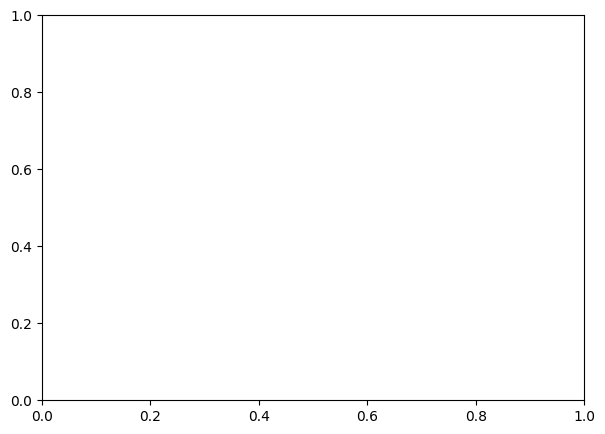

In [30]:
r_1m_sorted = np.sort(r_1m_normalized)
n_1m = len(r_1m_sorted)

# générer une grille de probabilités entre 0 et 1
phi_1m = np.linspace(1 / (n + 1), n / (n + 1), n)

q_exp_1m = -np.log(1 - phi_1m)

plt.figure(figsize=(7, 5))

plt.plot(q_exp_1m, r_1m_sorted, 'o', markersize=4, alpha=0.7, color='darkorange', label='Empirical quantiles')
plt.plot(q_exp_1m, q_exp_1m, '--', color='steelblue', linewidth=2, label='Exponential(1) reference')

plt.xlabel('Theoretical quantiles (Exponential(1))', fontsize=11)
plt.ylabel('Empirical quantiles of $|r|/E(|r|)$', fontsize=11)
plt.title('QQ-Plot: $|r|/E(|r|)$ vs Exponential(1)', fontsize=13)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Interprétation :

La queue de la distribution est plus lourde que celle de l'exponentielle — ce qui est un signal fort de heavy tails comme précédemment testé. Fait stylisé vérifé ! (et parfois même plus faible)